In [1]:
%matplotlib notebook
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
import time

import notebook_style
labels = notebook_style.labels

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1D-Heat-transfer-(Crank-Nicholson-method)" data-toc-modified-id="1D-Heat-transfer-(Crank-Nicholson-method)-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>1D Heat transfer (Crank-Nicholson method)</a></span><ul class="toc-item"><li><span><a href="#Crank-Nicholson-Formulation" data-toc-modified-id="Crank-Nicholson-Formulation-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Crank-Nicholson Formulation</a></span></li><li><span><a href="#Implement-in-Python" data-toc-modified-id="Implement-in-Python-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>Implement in Python</a></span></li></ul></li></ul></div>

# 1D Heat transfer (Crank-Nicholson method)

_notebook by Nico Liebers (nico.liebers@dlr.de), Deutsches Zentrum für Luft- und Raumfahrt (DLR), 2020_

    Code under MIT license, all other material under CC-BY-3.0 license

> This notebook is strongly inspired by the notebooks of the online course _["Practical Numerical Methods with Python"](https://github.com/numerical-mooc/numerical-mooc/) by Lorena A. Barba et al_


## Crank-Nicholson Formulation

The Crank-Nicholson-method uses the average of the explicit and the implicit formulation. In a general form using the factor $Phi$ as a weight between $T^{n+1}$ and $T^{n}$ results in the following formulation:

\begin{align}
T^{n+1}_{i}
&= \Phi \left[ \frac{\sigma_{i} + \sigma_{i+1}}{2} \left( T^{n+1}_{i+1} - T^{n+1}_i \right) - \frac{\sigma_{i-1} + \sigma_{i}}{2} \left(T^{n+1}_{i} - T^{n+1}_{i-1} \right) \right] \\
&+ (1 - \Phi) \left[ \frac{\sigma_{i} + \sigma_{i+1}}{2} \left( T^{n}_{i+1} - T^{n}_i \right) - \frac{\sigma_{i-1} + \sigma_{i}}{2} \left(T^{n}_{i} - T^{n}_{i-1} \right) \right]\\
&+ T^n_i + \Delta t \cdot s^n_{i}
\end{align}

Using $\Phi = \frac{1}{2}$ corresponds to the Crank-Nicholson Formulation, while $\Phi = 1$ results in the implicit formulation from the last lesson and $\Phi = 0$ results in the explicit formulation we introduced first. 

Reordering again all unknown terms to the left hand side and all known terms to the right hand side:

\begin{align}
&T^{n+1}_{i} + \Phi \left[ \frac{\sigma_{i-1} + \sigma_{i}}{2} \left(T^{n+1}_{i} - T^{n+1}_{i-1} \right) -\frac{\sigma_{i} + \sigma_{i+1}}{2} \left( T^{n+1}_{i+1} - T^{n+1}_i \right)  \right] \\
=& \; (1 - \Phi) \left[ \frac{\sigma_{i} + \sigma_{i+1}}{2} \left( T^{n}_{i+1} - T^{n}_i \right) - \frac{\sigma_{i-1} + \sigma_{i}}{2} \left(T^{n}_{i} - T^{n}_{i-1} \right) \right]
+ T^n_i + \Delta t \cdot s^n_{i}
\end{align}

Multply both sides by 2:

\begin{align}
& 2 T^{n+1}_{i} + \Phi \left[ (\sigma_{i-1} + \sigma_{i}) \left(T^{n+1}_{i} - T^{n+1}_{i-1} \right) - (\sigma_{i} + \sigma_{i+1}) \left( T^{n+1}_{i+1} - T^{n+1}_i \right)  \right] \\
=& \; (1 - \Phi) \left[ (\sigma_{i} + \sigma_{i+1}) \left( T^{n}_{i+1} - T^{n}_i \right) - (\sigma_{i-1} + \sigma_{i}) \left(T^{n}_{i} - T^{n}_{i-1} \right) \right]
+ 2 T^n_i + 2 \Delta t \cdot s^n_{i}
\end{align}

Which is an equation with three unknowns, which we bring to the left hand side and the known temperature to the right hand side:

\begin{align}
& \Phi (-\sigma_{i-1} - \sigma_{i}) T^{n+1}_{i-1} 
+ \left[ 2 + \Phi (\sigma_{i-1} + 2 \sigma_{i} + \sigma_{i+1}) \right] T^{n+1} 
+ \Phi (-\sigma_{i} - \sigma_{i+1}) T^{n+1}_{i+1} \\
=& \; (1 - \Phi)(\sigma_{i-1} + \sigma_{i})T^{n}_{i-1}
+ \left[2 + (\Phi - 1) (\sigma_{i-1} + 2 \sigma_{i} + \sigma_{i+1}) \right] T^{n}_i
+ (1 - \Phi)(\sigma_{i} + \sigma_{i+1})T^{n}_{i+1} + 2 \Delta t \cdot s^n_{i}
\end{align}

Taking the same example from lesson 04 we look at a small model of 5 elements with a fixed temperature on the left side and no heat flux in the right side:

<img src="./figures/heat 1d model 02.png" width="400"/>


We can formulate three of these equations, where we still have a total of two unknown temperatures:

For $i = 1$:
\begin{align}
& \Phi (-\sigma_{0} - \sigma_{1}) T^{n+1}_{0} 
+ \left[ 2 + \Phi (\sigma_{0} + 2 \sigma_{1} + \sigma_{2}) \right] T^{n+1}_1
+ \Phi (-\sigma_{1} - \sigma_{2}) T^{n+1}_{2} \\
=& \; (1 - \Phi)(\sigma_{0} + \sigma_{1})T^{n}_{0}
+ \left[2 + (\Phi - 1) (\sigma_{0} + 2 \sigma_{1} + \sigma_{2}) \right] T^{n}_1
+ (1 - \Phi)(\sigma_{1} + \sigma_{2})T^{n}_{2} 
\end{align}

For $i = 2$:
\begin{align}
& \Phi (-\sigma_{1} - \sigma_{2}) T^{n+1}_{1} 
+ \left[ 2 + \Phi (\sigma_{1} + 2 \sigma_{2} + \sigma_{3}) \right] T^{n+1}_2
+ \Phi (-\sigma_{2} - \sigma_{3}) T^{n+1}_{3} \\
=& \; (1 - \Phi)(\sigma_{1} + \sigma_{2})T^{n}_{1}
+ \left[2 + (\Phi - 1) (\sigma_{1} + 2 \sigma_{2} + \sigma_{3}) \right] T^{n}_2
+ (1 - \Phi)(\sigma_{2} + \sigma_{3})T^{n}_{3} 
\end{align}

For $i = 3$:
\begin{align}
& \Phi (-\sigma_{2} - \sigma_{3}) T^{n+1}_{2} 
+ \left[ 2 + \Phi (\sigma_{2} + 2 \sigma_{3} + \sigma_{4}) \right] T^{n+1}_3
+ \Phi (-\sigma_{3} - \sigma_{4}) T^{n+1}_{4} \\
=& \; (1 - \Phi)(\sigma_{2} + \sigma_{3})T^{n}_{2}
+ \left[2 + (\Phi - 1) (\sigma_{2} + 2 \sigma_{3} + \sigma_{4}) \right] T^{n}_3
+ (1 - \Phi)(\sigma_{3} + \sigma_{4})T^{n}_{4} 
\end{align}

The temperature at the left boundary is known at every time $T_{0}^{n}$ and $T_{0}^{n+1}$, so we bring them on the right side:
\begin{align}
& \left[ 2 + \Phi (\sigma_{0} + 2 \sigma_{1} + \sigma_{2}) \right] T^{n+1}_1
+ \Phi (-\sigma_{1} - \sigma_{2}) T^{n+1}_{2}
= \; \left[2 + (\Phi - 1) (\sigma_{0} + 2 \sigma_{1} + \sigma_{2}) \right] T^{n}_1
+ (1 - \Phi)(\sigma_{1} + \sigma_{2})T^{n}_{2} 
+ (1 - \Phi)(\sigma_{0} + \sigma_{1})T^{n}_{0}
+ \Phi (\sigma_{0} + \sigma_{1}) T^{n+1}_{0} 
\end{align}

On the right side we have a Neumann boundary condition with no heat flux, so:
$$
T_{4}^{n+1} = T_{3}^{n+1}
$$ 
and:
$$
T_{4}^{n} = T_{3}^{n}
$$

\begin{align}
& \Phi (-\sigma_{2} - \sigma_{3}) T^{n+1}_{2} 
+ \left[ 2 + \Phi (\sigma_{2} +  \sigma_{3} ) \right] T^{n+1}_3 \\
=& \; (1 - \Phi)(\sigma_{2} + \sigma_{3})T^{n}_{2}
+ \left[2 + (\Phi - 1) (\sigma_{2} +  \sigma_{3} ) \right] T^{n}_3
\end{align}

We have __3 unknowns and 3 equations! :__
\begin{align}
& \left[ 2 + \Phi (\sigma_{0} + 2 \sigma_{1} + \sigma_{2}) \right] T^{n+1}_1
+ \Phi (-\sigma_{1} - \sigma_{2}) T^{n+1}_{2} \\
=& \; \left[2 + (\Phi - 1) (\sigma_{0} + 2 \sigma_{1} + \sigma_{2}) \right] T^{n}_1
+ (1 - \Phi)(\sigma_{1} + \sigma_{2})T^{n}_{2} 
+ (1 - \Phi)(\sigma_{0} + \sigma_{1})T^{n}_{0}
+ \Phi (\sigma_{0} + \sigma_{1}) T^{n+1}_{0} 
\end{align}

\begin{align}
& \Phi (-\sigma_{1} - \sigma_{2}) T^{n+1}_{1} 
+ \left[ 2 + \Phi (\sigma_{1} + 2 \sigma_{2} + \sigma_{3}) \right] T^{n+1}_2
+ \Phi (-\sigma_{2} - \sigma_{3}) T^{n+1}_{3} \\
=& \; (1 - \Phi)(\sigma_{1} + \sigma_{2})T^{n}_{1}
+ \left[2 + (\Phi - 1) (\sigma_{1} + 2 \sigma_{2} + \sigma_{3}) \right] T^{n}_2
+ (1 - \Phi)(\sigma_{2} + \sigma_{3})T^{n}_{3} 
\end{align}

\begin{align}
& \Phi (-\sigma_{2} - \sigma_{3}) T^{n+1}_{2} 
+ \left[ 2 + \Phi (\sigma_{2} +  \sigma_{3} ) \right] T^{n+1}_3 \\
=& \; (1 - \Phi)(\sigma_{2} + \sigma_{3})T^{n}_{2}
+ \left[2 + (\Phi - 1) (\sigma_{2} +  \sigma_{3} ) \right] T^{n}_3
\end{align}

We can put this system of equations into matrix form:

$$
[A][x] = [A_2][b]+[b]_{b.c.}
$$

With $[x]$ with the temperatures $T^{n+1}$ we want to calculate, $[b]$ the temperatures $T^n$ of the current time step and $[b]_{b.c.}$ the boundary conditions. Matrix $[A]$ specifies the relations between the temperatures of the next time step and matrix $[A_2]$ between the temperatures of the present time step. They both are very similar. 

$$
\begin{align}     
    \left[
        \begin{array}{ccc}
             2 + \Phi (\sigma_{0} + 2 \sigma_{1} + \sigma_{2}) & 
             - \Phi (\sigma_{1} + \sigma_{2}) & 0  \\
            - \Phi (\sigma_{1} + \sigma_{2}) &  
            2 + \Phi (\sigma_{1} + 2 \sigma_{2} + \sigma_{3})  & 
            - \Phi (\sigma_{2} + \sigma_{3})  \\
             0 & - \Phi (\sigma_{2} + \sigma_{3}) & 
             2 + \Phi (\sigma_{2} +  \sigma_{3} ) 
        \end{array}
    \right] \cdot 
    \left[
        \begin{array}{c} 
            T_1^{n+1} \\
            T_2^{n+1} \\           
            T_3^{n+1}
        \end{array}
    \right] = 
    \left[
        \begin{array}{ccc}
            2 + (\Phi - 1) (\sigma_{0} + 2 \sigma_{1} + \sigma_{2}) & 
            (1 - \Phi)(\sigma_{1} + \sigma_{2}) & 0 \\
            (1 - \Phi)(\sigma_{1} + \sigma_{2}) & 
            2 + (\Phi - 1) (\sigma_{1} + 2 \sigma_{2} + \sigma_{3}) &
            (1 - \Phi)(\sigma_{2} + \sigma_{3}) \\
            0 & (1 - \Phi)(\sigma_{2} + \sigma_{3}) &
            2 + (\Phi - 1) (\sigma_{2} +  \sigma_{3})      
        \end{array} 
    \right] \cdot
     \left[
        \begin{array}{c} 
            T_1^{n} \\
            T_2^{n} \\           
            T_3^{n}
        \end{array}
    \right] +    
    \begin{bmatrix}
        (\sigma_{0} + \sigma_{1}) \left[ (1 - \Phi) T^{n}_{0} + \Phi T^{n+1}_{0} \right] \\
        0 \\
        0 
    \end{bmatrix}
\end{align}
$$

We build again our model:

## Implement in Python

In [2]:
def explicit1D_nofluxright(T, sigma):
    T[1:-1] += sigma[1:] * (T[2:] - T[1:-1]) - sigma[:-1] * (T[1:-1] - T[:-2])
    # no heat flux on right side
    T[-1] = T[-2]
    return T

In [3]:
def calc_A_matrix(sigma, Phi=.5):
    """
    Compute Matrix A for 1D model with dirichlet BC on left and 
    Neumann BC on right side
    """
    Nx = len(sigma)
    A_size = (Nx - 2)
    # Setup the diagonal of the operator.
    D = 2 + Phi * (sigma[:-2] + 2* sigma[1:-1] + sigma[2:])
    # Setup the Neumann condition for the last element.
    D[-1] -= Phi * (sigma[-2] + sigma[-1])
    # Setup the upper diagonal of the operator.
    U = -Phi * (sigma[1:-1] + sigma[2:])[:-1]
    # Setup the lower diagonal of the operator.
    L = -Phi * (sigma[:-2] + sigma[1:-1])[1:]
    # Assemble the operator.
    A = sparse.diags(diagonals=[D, U, L],
                 offsets=[0, 1, -1], shape=(A_size, A_size),
                 format="csr")
    return A
def calc_A2_matrix(sigma, Phi=.5):
    """
    Compute Matrix A for 1D model with dirichlet BC on left and 
    Neumann BC on right side
    """
    Nx = len(sigma)
    A_size = (Nx - 2)
    # Setup the diagonal of the operator.
    D = 2 + (Phi - 1) * (sigma[:-2] + 2* sigma[1:-1] + sigma[2:])
    # Setup the Neumann condition for the last element.
    D[-1] -= (Phi - 1) * (sigma[-2] + sigma[-1])
    # Setup the upper diagonal of the operator.
    U = (1 - Phi) * (sigma[1:-1] + sigma[2:])[:-1]
    # Setup the lower diagonal of the operator.
    L = (1 - Phi) * (sigma[:-2] + sigma[1:-1])[1:]
    # Assemble the operator.
    A2 = sparse.diags(diagonals=[D, U, L],
                 offsets=[0, 1, -1], shape=(A_size, A_size),
                 format="csr")
    return A2
def calc_b_vector(T, sigma, udx=0, Phi=.5):
    """
    Compute vector b + b_bc for 1D model with dirichlet BC on left and 
    Neumann BC (heat flux udx) on right side
    """
    b = np.zeros(len(T) - 2)
    # Set Dirichlet condition.
    b[0] += (Phi*T[0] + (1-Phi) * T[0]) * (sigma[0] + sigma[1])
    # Set Neumann condition.
    b[-1] += udx
    return b
def crank_nicholson_1D_nofluxright(T, sigma, A, A2, udx=0, Phi=.5):
    """
    Solve implicit matrix formulation, pass matrix A (only calculate once)
    """
    # Generate the right-hand side of the system.
    b = A2.dot(T[1:-1]) + calc_b_vector(T, sigma, udx, Phi)
    # Solve the system with scipy.linalg.solve.
    T[1:-1] = spsolve(A, b)
    # Apply the Neumann boundary condition.
    T[-1] = T[-2] 
    return T

In [4]:
d = 40 / 1000
Nx = 51
dx = d / (Nx - 1)
print("dx =", dx)
x = np.arange(Nx) * dx

alpha = 1e-5 * np.ones(Nx)
alpha[Nx//3:] /= 5
alpha[-Nx//3:] /= 2

dt_CLF = dx**2 / 2 / np.max(alpha)
print("limit for numerical stability (explicit scheme): dt =", dt_CLF, "s")

# try larger and smaller time steps
dt_explicit = dt_CLF / 4

print("used time step (explicit scheme): dt =", dt_explicit, "s")

dt_factor = 2**7

dt_implicit = dt_explicit * dt_factor
print("used time step (implicit scheme): dt =", dt_implicit, "s")

print("dt_implicit / dt_explicit =", dt_factor)
print("dt_implicit / dt_CLF =", dt_implicit / dt_CLF)

T = np.zeros(Nx)
T[0] = 100

dx = 0.0008
limit for numerical stability (explicit scheme): dt = 0.032 s
used time step (explicit scheme): dt = 0.008 s
used time step (implicit scheme): dt = 1.024 s
dt_implicit / dt_explicit = 128
dt_implicit / dt_CLF = 32.0


<IPython.core.display.Javascript object>


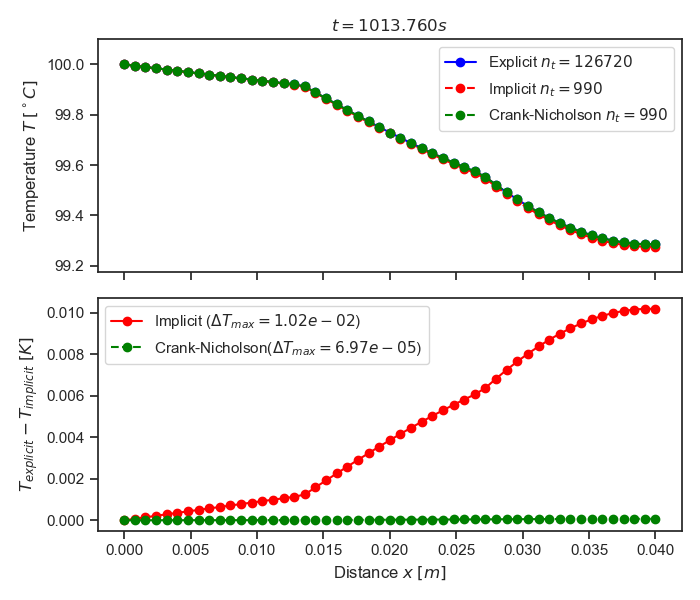

In [5]:
# number of time steps to compute
nt = 1000  
# update plots after how many iterations
i_snap = nt//100

alpha_mean = (alpha[1:] + alpha[:-1])/2
#alpha_mean = 2*(alpha[1:] * alpha[:-1])/(alpha[1:] + alpha[:-1])
sigma_explicit = alpha_mean * dt_explicit / dx**2
sigma_implicit = alpha * dt_implicit / dx**2

T1 = np.copy(T)
T2 = np.copy(T)
T3 = np.copy(T)
#A_explicit = calc_A_matrix(Nx-2, sigma_implicit, Phi=0)
A_implicit = calc_A_matrix(sigma_implicit, Phi=1)
A2_implicit = calc_A2_matrix(sigma_implicit, Phi=1)
A_CN = calc_A_matrix(sigma_implicit, Phi=.5)
A2_CN = calc_A2_matrix(sigma_implicit, Phi=.5)
calc_time = np.zeros(3)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7.0, 6.0))
ax1, ax2 = ax
plt.ion()
for i in range(nt):        
    for ii in range(dt_factor):
        T1 = explicit1D_nofluxright(T1, sigma_explicit)
    T2 = crank_nicholson_1D_nofluxright(T2, sigma_implicit, A_implicit, A2_implicit, Phi=1)
    T3 = crank_nicholson_1D_nofluxright(T3, sigma_implicit, A_CN, A2_CN, Phi=.5)
    
    if i % i_snap == 0:
        plt.sca(ax1)
        plt.cla()
        plt.title(r"$t = %.3f s$" %(i*dt_implicit) )        
        plt.ylabel(r'Temperature $T \; [^\circ C]$')
        plt.plot(x, T1, "o-", color="b", 
                 label=r"Explicit $n_t = %d$" %(i*dt_factor))
        plt.plot(x, T2, "o--", color="r", 
                 label=r"Implicit $n_t = %d$" %(i))
        plt.plot(x, T3, "o--", color="g", 
                 label=r"Crank-Nicholson $n_t = %d$" %(i))
        plt.legend()
        
        plt.sca(ax2)
        plt.cla()
        plt.ylabel(r'$T_{explicit} - T_{implicit} \; [K]$')
        error = T1-T2
        plt.plot(x, error, "o-", color="r", label=f"Implicit ($\Delta T_{{max}} = {np.max(np.abs(error)): .2e}$)")
        error = T1-T3
        plt.plot(x, error, "o--", color="g", label=f"Crank-Nicholson($\Delta T_{{max}} = {np.max(np.abs(error)): .2e}$)")
        plt.xlabel(r'Distance $x \; [m]$')
        plt.legend()
        
        ax1.set_ylim((
            np.min([T1.min(), T2.min(), T3.min()]) - .1,
            np.max([T1.max(), T2.max(), T3.max()]) + .1
                     ))
        
        #[_ax.relim() for _ax in ax]
        #[_ax.autoscale(tight=True) for _ax in ax]
        plt.tight_layout()
        fig.canvas.flush_events()
        fig.canvas.draw()    
        plt.pause(.2);